In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

YEARS = set()

table = dict()
table["population"]  = pd.read_csv("data/population.csv")
table["pcgdp"]       = pd.read_csv("data/pcgdp.csv")
table["gini"]        = pd.read_csv("data/gini.csv")
table["electricity"] = pd.read_csv("data/electricity.csv")
table["life_exp"]    = pd.read_csv("data/life_exp.csv")
winter_raw = pd.read_csv("data/winter.csv")



DROP_FROM = 1960
DROP_TO = 1985
years_to_drop = [str(i) for i in range(DROP_FROM, DROP_TO)]
for key, _ in table.items():
    print(key)
    table[key] = table[key].drop(columns=years_to_drop+[
        "Country Name", "Indicator Name", "Indicator Code",
        "Unnamed: 62", "2017"])
    table[key] = table[key].rename(index=str, columns={"Country Code":"Country"})

population
pcgdp
gini
electricity
life_exp


In [24]:
table["population"].head(3)

,Country,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,ABW,63026.0,62644.0,61833.0,61079.0,61032.0,62149.0,64622.0,68235.0,72504.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,AFG,11783050.0,11601041.0,11502761.0,11540888.0,11777609.0,12249114.0,12993657.0,13981231.0,15095099.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,AGO,10609042.0,10921037.0,11218268.0,11513968.0,11827237.0,12171441.0,12553446.0,12968345.0,13403734.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0


In [25]:
table["population"].describe()

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,2.620000e+02,2.620000e+02,2.610000e+02,2.610000e+02,2.610000e+02,...,2.630000e+02,2.630000e+02,2.630000e+02,2.630000e+02,2.630000e+02,2.620000e+02,2.620000e+02,2.620000e+02,2.620000e+02,2.620000e+02
mean,1.928608e+08,1.964591e+08,2.001500e+08,2.038812e+08,2.076147e+08,2.098121e+08,2.134405e+08,2.178132e+08,2.213804e+08,2.249049e+08,...,2.673651e+08,2.708530e+08,2.743725e+08,2.779127e+08,2.814389e+08,2.861268e+08,2.898075e+08,2.935173e+08,2.972352e+08,3.009801e+08
std,6.148648e+08,6.264682e+08,6.383947e+08,6.504300e+08,6.624122e+08,6.720817e+08,6.836446e+08,6.961000e+08,7.073090e+08,7.183989e+08,...,8.526417e+08,8.631013e+08,8.736656e+08,8.842899e+08,8.949399e+08,9.073509e+08,9.183373e+08,9.293896e+08,9.404528e+08,9.515836e+08
min,8.174000e+03,8.356000e+03,8.550000e+03,8.752000e+03,8.947000e+03,9.003000e+03,9.053000e+03,9.109000e+03,9.156000e+03,9.190000e+03,...,1.007500e+04,1.004700e+04,1.002800e+04,1.002500e+04,1.005700e+04,1.027900e+04,1.081900e+04,1.090800e+04,1.100100e+04,1.109700e+04
25%,8.821530e+05,9.044762e+05,9.269285e+05,9.496710e+05,9.730455e+05,1.023904e+06,1.045433e+06,1.062800e+06,1.088569e+06,1.112846e+06,...,1.324970e+06,1.363216e+06,1.425982e+06,1.443678e+06,1.465471e+06,1.415726e+06,1.431560e+06,1.447306e+06,1.471523e+06,1.522803e+06
50%,6.427280e+06,6.515834e+06,6.701350e+06,6.858332e+06,6.999618e+06,7.129366e+06,7.147575e+06,7.382000e+06,7.495000e+06,7.583954e+06,...,8.856800e+06,9.219637e+06,9.298515e+06,9.378126e+06,9.460802e+06,9.624267e+06,9.746730e+06,9.879129e+06,1.002115e+07,1.012427e+07
75%,4.080169e+07,4.144044e+07,4.208959e+07,4.275645e+07,4.345151e+07,4.230852e+07,4.276932e+07,4.374796e+07,4.419463e+07,4.464154e+07,...,4.952938e+07,4.994594e+07,5.038575e+07,5.087028e+07,5.140827e+07,5.249529e+07,5.318760e+07,5.396340e+07,5.493841e+07,5.590466e+07
max,4.846338e+09,4.932114e+09,5.020001e+09,5.108813e+09,5.197758e+09,5.288103e+09,5.375489e+09,5.459754e+09,5.544873e+09,5.628791e+09,...,6.683228e+09,6.766303e+09,6.849573e+09,6.932881e+09,7.014999e+09,7.099549e+09,7.185078e+09,7.271228e+09,7.357370e+09,7.444027e+09


In [26]:
table["pcgdp"].head(3)

,Country,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25921.026052,27546.899390,24631.434860,24271.940421,25324.720362,NaN,NaN,NaN,NaN,NaN
1,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,369.835796,373.361116,445.893298,553.300289,603.537023,669.009051,638.612543,629.345250,569.577923,561.778746
2,AGO,630.074985,612.07484,595.857754,580.555025,847.766724,823.792184,965.361296,438.32052,393.784521,...,2878.837144,3868.578883,3347.844850,3529.053482,4299.012889,4598.249988,4804.616884,4709.312024,3695.793748,3308.700233


In [27]:
table["pcgdp"].describe()

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,193.000000,194.000000,198.000000,200.000000,204.000000,222.000000,222.000000,222.000000,226.000000,228.000000,...,251.000000,250.000000,250.000000,250.000000,250.000000,246.000000,247.000000,246.000000,245.000000,237.000000
mean,3708.602925,4276.008170,4882.254088,5289.225844,5366.815178,5893.663224,6001.202196,6313.158199,6057.158066,6364.049259,...,14184.809671,15282.951233,13588.866203,14298.180545,15736.871568,15104.972230,15573.331378,15515.773872,13917.350066,12745.478087
std,5449.422142,6609.262750,7891.228805,8595.995495,8642.832941,9944.773578,10110.437511,10858.826337,10352.997481,11032.680085,...,22797.246930,24430.024267,21079.805989,21638.192903,23893.064298,21606.460500,22787.792617,22812.716950,20393.585544,17172.690157
min,156.656353,125.287981,145.699579,148.984408,94.271269,94.880198,137.982562,110.494288,80.190056,65.676877,...,170.799900,196.247263,204.944650,231.194326,260.479907,265.285605,282.755525,312.748979,300.676557,285.727442
25%,456.795608,473.673458,509.822772,545.261894,518.240851,605.904006,584.260446,502.122344,531.292854,510.524476,...,1157.590929,1372.774525,1255.853139,1555.547218,1703.504313,1770.871134,1861.059425,2010.251039,1862.167274,1772.215255
50%,1203.028340,1368.165672,1476.421044,1454.197901,1461.866400,1592.189778,1585.728777,1552.272887,1529.089541,1637.068757,...,4324.876427,4958.146402,4622.612335,5133.442629,5765.315089,6338.000552,6353.826383,6382.782373,5814.863134,5274.546008
75%,4756.409365,5515.042743,5695.631608,5853.774592,6052.743826,6515.809696,5920.502507,6668.179237,6342.492165,6147.517252,...,15931.432703,17724.340844,14671.958610,15639.528114,17243.737156,16260.804677,16604.059578,16474.291830,16129.049283,14912.686543
max,37553.357951,52174.842059,63043.178228,68434.228393,68576.584716,84286.696350,83732.701453,91654.119007,85421.725834,89404.073321,...,170156.694368,192989.189527,152111.598027,144246.368775,162009.877819,149295.646044,173528.150454,179308.075616,168146.015281,100738.684223


In [28]:
table["electricity"].head(3)

,Country,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,ABW,NaN,NaN,NaN,NaN,NaN,88.445351,88.780846,89.115829,89.447754,...,92.838821,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145
1,AFG,NaN,NaN,NaN,NaN,NaN,0.010000,0.010000,0.010000,0.010000,...,33.748680,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138
2,AGO,NaN,NaN,NaN,NaN,NaN,11.397808,12.579379,13.760440,14.938441,...,37.500000,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607


In [29]:
table["electricity"].describe()

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,0.0,0.0,0.0,0.0,0.0,251.000000,251.000000,251.000000,251.000000,252.000000,...,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,NaN,NaN,NaN,NaN,NaN,66.468235,66.970359,67.658785,68.201201,68.819778,...,77.724625,78.258279,78.813311,78.801051,79.899944,80.799870,81.297611,82.082864,82.750795,83.550868
std,NaN,NaN,NaN,NaN,NaN,37.450121,37.142282,36.800202,36.501999,36.156386,...,30.281923,30.050033,29.788237,29.923153,28.842930,28.300432,28.055591,27.352842,26.898025,25.961317
min,NaN,NaN,NaN,NaN,NaN,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.502950,1.021752,1.900000,0.000000,3.918669,4.912345,5.915033,6.923728,7.252090,7.588477
25%,NaN,NaN,NaN,NaN,NaN,32.058917,33.616261,35.203474,36.787632,36.670809,...,59.042709,60.559383,62.982807,64.350000,66.062515,68.796662,69.796356,71.673798,71.500000,75.920000
50%,NaN,NaN,NaN,NaN,NaN,85.381281,86.442174,86.580068,87.418197,87.841311,...,94.896184,95.501411,96.779938,97.000000,97.490799,97.824120,98.385853,98.701241,99.032677,99.427812
75%,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [30]:
winter_raw.head(5)

,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
0,1924,Chamonix,Biathlon,Biathlon,"BERTHET, G.",FRA,Men,Military Patrol,Bronze
1,1924,Chamonix,Biathlon,Biathlon,"MANDRILLON, C.",FRA,Men,Military Patrol,Bronze
2,1924,Chamonix,Biathlon,Biathlon,"MANDRILLON, Maurice",FRA,Men,Military Patrol,Bronze
3,1924,Chamonix,Biathlon,Biathlon,"VANDELLE, André",FRA,Men,Military Patrol,Bronze
4,1924,Chamonix,Biathlon,Biathlon,"AUFDENBLATTEN, Adolf",SUI,Men,Military Patrol,Gold


In [31]:
medals = dict() # by countries code => by years


for i in range(len(winter_raw)):
    row = dict(winter_raw.iloc[i, :])
    ccode = row["Country"]
    year  = row["Year"]
    medal = row["Medal"]
    if int(year) < DROP_TO:
        continue
        
    YEARS.add(year)
    medals.setdefault(ccode, dict()).setdefault(year, 0)
    medals[ccode][year] += 1
print("total country medalists", len(medals))

total country medalists 42


In [32]:
winter = pd.DataFrame(table["population"]["Country"])
for i, year in enumerate(YEARS):
    winter[year] = np.zeros(len(winter))
    for ccode, _ in medals.items():
        medals[ccode].setdefault(year, 0)
        winter.loc[winter.Country==ccode, year] = medals[ccode][year]

In [33]:
winter.head(5)
a = []
for i in range(len(winter)):
    row = winter.iloc[i]
    if row.drop(columns="Country").all():
        print(row.Country)

AUT
CAN
FIN
FRA
ITA
JPN
NOR
SWE
USA


In [34]:
winter.loc[winter.Country=="RUS"]

,Country,1988,1992,1994,1998,2002,2006,2010,2014
200,RUS,0.0,0.0,36.0,53.0,40.0,41.0,25.0,68.0


In [35]:
for key, _ in table.items():
    table[key] = table[key].sort_values(by=["Country"]).drop(columns=["Country"])
    table[key] = table[key].fillna(table[key].mean()).fillna(0)
    std = table[key][str(year)].std()
    table[key][str(year)] = (table[key][str(year)] - table[key][str(year)].mean()) / std
    #table[key] /= table[key].max() - table[key].min()
    
winter = winter.sort_values(by=["Country"]).drop(columns=["Country"])
winter = winter.fillna(winter.mean()).fillna(0)
#std = winter[year].std()
#winter[year] = (winter[year] - winter[year].mean()) / std
#winter /= winter.max() - winter.min()
#winter /= winter.sum()

In [36]:
winter.head(5)

,1988,1992,1994,1998,2002,2006,2010,2014
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
winter.iloc[0]
for key, val in table.items():
    table[key].to_csv(key+"_edited.csv")

In [38]:
X  = [] # population, pcgdp normed in year = year
y  = [] # medals
y2 = [] # classification, if have medals

feature_names = ["population", "pcgdp", "electricity", "gini", "life_exp"]
feature_names = ["population", "pcgdp", "life_exp"]
mean_year_diff = 7
def split(test_year, regression=True):
    X_train, y_train, X_test, y_test = [], [], [], []
    y2_train, y2_test = [], []
    for year in YEARS:
        start = year - mean_year_diff + 1
        years_ = [str(i) for i in range(start, year + 1)]
        
        for i in range(len(winter)):    
            if start < min(YEARS):
                continue
            features = []
            for feature in feature_names:
                a = np.array(table[feature][years_].iloc[i])
                features.append(a.mean())

            target = float(winter[year].iloc[i])
            if not year in test_year:
                X_train.append(features)
                y_train.append(target)
                y2_train.append(target > 0)
            else:
                X_test.append(features)
                y_test.append(target)
                y2_test.append(target > 0)
                
    if not regression:
        y_train, y_test = y2_train, y2_test
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [39]:
X, y, _, _ = split([2020], True)
_, y2, _, _ = split([2020], False)
print(len(X), len(y), len(y2))

1584 1584 1584


In [40]:
def get_only_positive(X, y):
    print(len(X))
    X_, y_ = [], []
    for i in range(len(y)):
        if y[i] <= 0: 
            continue
        X_.append(X[i])
        y_.append(y[i])
    return np.array(X_), np.array(y_)

X_, y_ = get_only_positive(X, y)
print(len(y_))

1584
115


In [41]:
from sklearn import datasets, linear_model, ensemble
from sklearn.model_selection import cross_val_score

def test(X_, y_, X, y2):
    models_reg = {"linreg" : linear_model.LinearRegression(),
                 "ridge": linear_model.Ridge(),
                 "huber": linear_model.HuberRegressor()}

    X_train, y_train = X_, y_

    for k, m in models_reg.items():
        print(k, cross_val_score(m, X_train, y_train, cv=10).mean()) 


    models_clf = {"logreg" : linear_model.LogisticRegression(),
                 "ridge": linear_model.RidgeClassifier(),
                 "rf": ensemble.RandomForestClassifier(),
                 "sgd": linear_model.SGDClassifier()}

    X_train, y_train = X, y2

    for k, m in models_clf.items():
        print(k, cross_val_score(m, X_train, y_train, cv=10).mean())


test(X_, y_, X, y2)

linreg 0.017377208434622825
ridge 0.01737692288167998
huber -0.134729065195452
logreg 0.9274096802508218
ridge 0.9261438574660119


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0749850291551449e-16 / 1.1102230246251565e-16
  RuntimeWarning)


rf 0.9374805344821728
sgd 0.9274096802508218


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/s

In [44]:
def test2(X_train, y_train, X_test, y_test, reg=True):
    models = {"linreg" : linear_model.LinearRegression(),
                 "ridge": linear_model.Ridge(),
                 "huber": linear_model.HuberRegressor(),
                 "rf" : ensemble.RandomForestRegressor()}
    models_clf = {"logreg" : linear_model.LogisticRegression(),
                 "ridge": linear_model.RidgeClassifier(),
                 "rf": ensemble.RandomForestClassifier(),
                 "sgd": linear_model.SGDClassifier()}
    
    if not reg:
        models = models_clf

    for k, m in models.items():
        m = m.fit(X_train, y_train)
        print(k, m.score(X_test, y_test))
        if (k == 'rf'):
            print(m.feature_importances_)



# Regression over counties with medals
print(len(X))
X_train, y_train, X_test, y_test = split([2014], True)
X_train, y_train = get_only_positive(X_train, y_train)
X_test, y_test = get_only_positive(X_test, y_test)
print(len(X_train), len(y_train), len(X_test), len(y_test))
test2(X_train, y_train, X_test, y_test, True)
# classification over all (>0 medals)
X_train, y_train, X_test, y_test = split([2014], False)
test2(X_train, y_train, X_test, y_test, False)

1584
1320
264
95 95 20 20
linreg -0.26293545295407617
ridge -0.26153812122346265
huber 0.08291388516723941
rf 0.5449673546117928
[0.45827747 0.26322664 0.27849589]


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.747458860117493e-17 / 1.1102230246251565e-16
  RuntimeWarning)


logreg 0.9242424242424242
ridge 0.9242424242424242
rf 0.9242424242424242
[0.38013892 0.27792565 0.34193543]
sgd 0.9242424242424242


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0965297431221372e-16 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119166c18>,
      dtype=object)

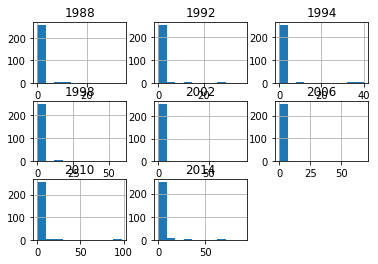

In [43]:
winter.hist()

In [48]:
for year in YEARS:
    print(year)
    print(len(winter.loc[winter[year] > 0]) / len(winter))

1988
0.03787878787878788
1992
0.056818181818181816
1994
0.06818181818181818
1998
0.07196969696969698
2002
0.06818181818181818
2006
0.07575757575757576
2010
0.07575757575757576
2014
0.07575757575757576
